In [ ]:
##ARQUIVO DE TESTE: DIFERENTES FORMAS DE TRATAR VALORES NULOS

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [74]:

df = pd.read_csv('coronarias.csv', sep=';', decimal=',', na_values=['NaN', '.'])
df.replace('.', np.nan, inplace=True)
categoricas = ['SEXO','AH3','INFARTO','ANGEST','DIAB','ARTER','ARRIT','TABAG4','OBESO']
quantitativas = ['IDADE1','ALTURA','PESO','IMC','COL','TRIG','PSR','PDR']


In [75]:
# Funções auxiliares para sumarização
from scipy import stats

def resumo_quantitativas(dfq: pd.DataFrame) -> pd.DataFrame:
    estat = {}
    for c in dfq.columns:
        s = dfq[c].dropna()
        if s.empty:
            estat[c] = {
                'n': len(dfq[c]), 'n_na': dfq[c].isna().sum(), 'perc_na': dfq[c].isna().mean()*100,
                'media': np.nan, 'mediana': np.nan, 'desvio': np.nan, 'variancia': np.nan,
                'q1': np.nan, 'q3': np.nan, 'p5': np.nan, 'p95': np.nan,
                'min': np.nan, 'max': np.nan,
            }
            continue
        estat[c] = {
            'n': len(dfq[c]), 'n_na': dfq[c].isna().sum(), 'perc_na': dfq[c].isna().mean()*100,
            'media': s.mean(), 'mediana': s.median(), 'desvio': s.std(ddof=1), 'variancia': s.var(ddof=1),
            'q1': s.quantile(0.25), 'q3': s.quantile(0.75), 'p5': s.quantile(0.05), 'p95': s.quantile(0.95),
            'min': s.min(), 'max': s.max(),
        }
    return pd.DataFrame(estat).T


def resumo_categoricas(dfc: pd.DataFrame) -> dict:
    tabelas = {}
    for c in dfc.columns:
        cont = dfc[c].value_counts(dropna=False).rename('freq')
        perc = (cont / cont.sum() * 100).rename('perc')
        tabelas[c] = pd.concat([cont, perc], axis=1)
    return tabelas


In [76]:
# Cenário A: Remover linhas com faltantes nas variáveis selecionadas
cols = [c for c in categoricas + quantitativas if c in df.columns]

for col in quantitativas:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
cenario_a = df.dropna(subset=cols)
resumo_q_a = resumo_quantitativas(cenario_a[[c for c in quantitativas if c in cenario_a.columns]])
resumo_c_a = resumo_categoricas(cenario_a[[c for c in categoricas if c in cenario_a.columns]])

print('Cenário A (drop linhas) - quantitativas:')
resumo_q_a


Cenário A (drop linhas) - quantitativas:


,n,n_na,perc_na,media,mediana,desvio,variancia,q1,q3,p5,p95,min,max
IDADE1,350.0,0.0,0.0,58.988571,60.00,11.017563,121.386688,52.00,67.00,40.45,76.000,22.0,87.00
ALTURA,350.0,0.0,0.0,1.658457,1.66,0.083724,0.007010,1.60,1.72,1.52,1.780,1.4,1.85
PESO,350.0,0.0,0.0,72.674286,72.00,12.933250,167.268964,64.00,80.00,53.45,94.550,42.0,136.00
IMC,350.0,0.0,0.0,26.366114,25.97,3.897238,15.188466,23.85,28.37,21.01,32.801,16.0,42.92
COL,350.0,0.0,0.0,215.574286,214.00,56.734529,3218.806787,179.25,242.00,140.00,300.000,74.0,620.00
TRIG,350.0,0.0,0.0,174.322857,154.00,99.538657,9907.944175,110.00,215.00,74.45,335.950,38.0,888.00
PSR,350.0,0.0,0.0,14.171429,14.00,2.300937,5.294310,12.00,16.00,11.00,18.000,9.0,23.00
PDR,350.0,0.0,0.0,8.514286,8.00,1.144851,1.310684,8.00,9.00,7.00,10.000,5.0,14.00


In [77]:
# Cenário B: Imputar média nas quantitativas e moda nas categóricas
cenario_b = df.copy()
# Quantitativas -> média
for c in quantitativas:
    if c in cenario_b.columns:
        cenario_b[c] = pd.to_numeric(cenario_b[c], errors='coerce')
        media_c = cenario_b[c].mean(skipna=True)
        cenario_b[c] = cenario_b[c].fillna(media_c)
# Categóricas -> moda
for c in categoricas:
    if c in cenario_b.columns:
        moda_vals = cenario_b[c].mode(dropna=True)
        if not moda_vals.empty:
            cenario_b[c] = cenario_b[c].fillna(moda_vals.iloc[0])

resumo_q_b = resumo_quantitativas(cenario_b[[c for c in quantitativas if c in cenario_b.columns]])
resumo_c_b = resumo_categoricas(cenario_b[[c for c in categoricas if c in cenario_b.columns]])

print('Cenário B (imputação: média p/ quantitativas, moda p/ categóricas) - quantitativas:')
resumo_q_b


Cenário B (imputação: média p/ quantitativas, moda p/ categóricas) - quantitativas:


,n,n_na,perc_na,media,mediana,desvio,variancia,q1,q3,p5,p95,min,max
IDADE1,500.0,0.0,0.0,58.332000,59.000000,11.264082,126.879535,52.0000,66.0000,38.0000,75.0000,11.00,87.00
ALTURA,500.0,0.0,0.0,1.656542,1.660000,0.085543,0.007318,1.6000,1.7200,1.5195,1.7805,1.38,1.86
PESO,500.0,0.0,0.0,72.868687,72.000000,12.879623,165.884699,64.0000,80.0000,54.0000,95.0000,42.00,136.00
IMC,500.0,0.0,0.0,26.438841,26.275000,3.789429,14.359773,24.0525,28.3725,21.0075,33.3165,16.00,42.92
COL,500.0,0.0,0.0,214.988636,214.988636,52.087081,2713.064014,183.0000,236.0000,140.0000,299.0500,74.00,620.00
TRIG,500.0,0.0,0.0,172.051887,168.000000,88.618803,7853.292302,115.0000,199.2500,75.9500,305.1000,38.00,888.00
PSR,500.0,0.0,0.0,14.102616,14.000000,2.222930,4.941416,12.0000,16.0000,11.0000,18.0000,9.00,23.00
PDR,500.0,0.0,0.0,8.492958,8.000000,1.137999,1.295041,8.0000,9.0000,7.0000,10.0000,5.00,14.00


In [78]:
# Cenário C: Remove linhas com mais de 1 NaN nas quantitativas, o restante preenche com a média
cenario_c = df.copy()

# Garante que todas quantitativas são numéricas
for c in quantitativas:
    if c in cenario_c.columns:
        cenario_c[c] = pd.to_numeric(cenario_c[c], errors='coerce')

# Conta NaNs por linha nas quantitativas
nan_counts = cenario_c[quantitativas].isna().sum(axis=1)

# Remove linhas com mais de 1 NaN nas quantitativas
cenario_c = cenario_c[nan_counts <= 1].copy()

# Preenche NaNs restantes nas quantitativas com a média
for c in quantitativas:
    if c in cenario_c.columns:
        media_c = cenario_c[c].mean(skipna=True)
        cenario_c[c] = cenario_c[c].fillna(media_c)

# Resumos
resumo_q_c = resumo_quantitativas(cenario_c[[c for c in quantitativas if c in cenario_c.columns]])
resumo_c_c = resumo_categoricas(cenario_c[[c for c in categoricas if c in cenario_c.columns]])

print('Cenário C (drop >1 NaN nas quantitativas, resto preenche com média):')
display(resumo_q_c)

Cenário C (drop >1 NaN nas quantitativas, resto preenche com média):


,n,n_na,perc_na,media,mediana,desvio,variancia,q1,q3,p5,p95,min,max
IDADE1,426.0,0.0,0.0,58.920188,60.000,10.904428,118.906556,52.00,67.0000,42.00,76.0000,22.0,87.00
ALTURA,426.0,0.0,0.0,1.656033,1.660,0.085513,0.007312,1.60,1.7200,1.51,1.7800,1.4,1.86
PESO,426.0,0.0,0.0,72.751174,72.000,12.682515,160.846175,64.00,80.0000,54.00,93.0000,42.0,136.00
IMC,426.0,0.0,0.0,26.487394,26.125,3.890242,15.133984,24.02,28.4925,21.01,33.4225,16.0,42.92
COL,426.0,0.0,0.0,215.517730,214.000,55.498715,3080.107334,179.25,242.0000,140.00,300.0000,74.0,620.00
TRIG,426.0,0.0,0.0,173.053922,156.500,95.297118,9081.540738,111.00,212.0000,74.25,311.7500,38.0,888.00
PSR,426.0,0.0,0.0,14.145540,14.000,2.299349,5.287004,12.00,16.0000,11.00,18.0000,9.0,23.00
PDR,426.0,0.0,0.0,8.507042,8.000,1.127703,1.271715,8.00,9.0000,7.00,10.0000,5.0,14.00


In [79]:
# Cenário D: Remove linhas com mais de 2 NaN nas quantitativas, o restante preenche com a média
cenario_d = df.copy()

# Garante que todas quantitativas são numéricas
for c in quantitativas:
    if c in cenario_d.columns:
        cenario_d[c] = pd.to_numeric(cenario_d[c], errors='coerce')

# Conta NaNs por linha nas quantitativas
nan_counts_d = cenario_d[quantitativas].isna().sum(axis=1)

# Remove linhas com mais de 2 NaN nas quantitativas
cenario_d = cenario_d[nan_counts_d <= 2].copy()

# Preenche NaNs restantes nas quantitativas com a média
for c in quantitativas:
    if c in cenario_d.columns:
        media_c = cenario_d[c].mean(skipna=True)
        cenario_d[c] = cenario_d[c].fillna(media_c)

# Resumos
resumo_q_d = resumo_quantitativas(cenario_d[[c for c in quantitativas if c in cenario_d.columns]])
resumo_c_d = resumo_categoricas(cenario_d[[c for c in categoricas if c in cenario_d.columns]])

print('Cenário D (drop >2 NaN nas quantitativas, resto preenche com média):')
resumo_q_d

Cenário D (drop >2 NaN nas quantitativas, resto preenche com média):


,n,n_na,perc_na,media,mediana,desvio,variancia,q1,q3,p5,p95,min,max
IDADE1,491.0,0.0,0.0,58.354379,59.000000,11.308868,127.890486,52.000,66.00,38.000,75.000,11.00,87.00
ALTURA,491.0,0.0,0.0,1.656701,1.660000,0.086256,0.007440,1.600,1.72,1.515,1.785,1.38,1.86
PESO,491.0,0.0,0.0,72.845214,72.000000,12.975506,168.363747,64.000,80.00,54.000,95.000,42.00,136.00
IMC,491.0,0.0,0.0,26.432199,26.200000,3.821331,14.602568,24.025,28.39,20.985,33.375,16.00,42.92
COL,491.0,0.0,0.0,215.069124,215.069124,52.169072,2721.612094,183.000,236.00,140.000,299.500,74.00,620.00
TRIG,491.0,0.0,0.0,171.992840,168.000000,89.220284,7960.259140,115.000,199.50,75.500,306.000,38.00,888.00
PSR,491.0,0.0,0.0,14.104294,14.000000,2.227693,4.962614,12.000,16.00,11.000,18.000,9.00,23.00
PDR,491.0,0.0,0.0,8.488753,8.000000,1.139449,1.298343,8.000,9.00,7.000,10.000,5.00,14.00


In [80]:
# Comparação lado a lado das quantitativas entre os cenários
comparacao_q = resumo_q_a.join(resumo_q_b, lsuffix='_drop', rsuffix='_media')
comparacao_n = comparacao_q.join(resumo_q_c, rsuffix='_drop1NaN')
comparacao_n

,n_drop,n_na_drop,perc_na_drop,media_drop,mediana_drop,desvio_drop,variancia_drop,q1_drop,q3_drop,p5_drop,...,media,mediana,desvio,variancia,q1,q3,p5,p95,min,max
IDADE1,350.0,0.0,0.0,58.988571,60.00,11.017563,121.386688,52.00,67.00,40.45,...,58.920188,60.000,10.904428,118.906556,52.00,67.0000,42.00,76.0000,22.0,87.00
ALTURA,350.0,0.0,0.0,1.658457,1.66,0.083724,0.007010,1.60,1.72,1.52,...,1.656033,1.660,0.085513,0.007312,1.60,1.7200,1.51,1.7800,1.4,1.86
PESO,350.0,0.0,0.0,72.674286,72.00,12.933250,167.268964,64.00,80.00,53.45,...,72.751174,72.000,12.682515,160.846175,64.00,80.0000,54.00,93.0000,42.0,136.00
IMC,350.0,0.0,0.0,26.366114,25.97,3.897238,15.188466,23.85,28.37,21.01,...,26.487394,26.125,3.890242,15.133984,24.02,28.4925,21.01,33.4225,16.0,42.92
COL,350.0,0.0,0.0,215.574286,214.00,56.734529,3218.806787,179.25,242.00,140.00,...,215.517730,214.000,55.498715,3080.107334,179.25,242.0000,140.00,300.0000,74.0,620.00
TRIG,350.0,0.0,0.0,174.322857,154.00,99.538657,9907.944175,110.00,215.00,74.45,...,173.053922,156.500,95.297118,9081.540738,111.00,212.0000,74.25,311.7500,38.0,888.00
PSR,350.0,0.0,0.0,14.171429,14.00,2.300937,5.294310,12.00,16.00,11.00,...,14.145540,14.000,2.299349,5.287004,12.00,16.0000,11.00,18.0000,9.0,23.00
PDR,350.0,0.0,0.0,8.514286,8.00,1.144851,1.310684,8.00,9.00,7.00,...,8.507042,8.000,1.127703,1.271715,8.00,9.0000,7.00,10.0000,5.0,14.00


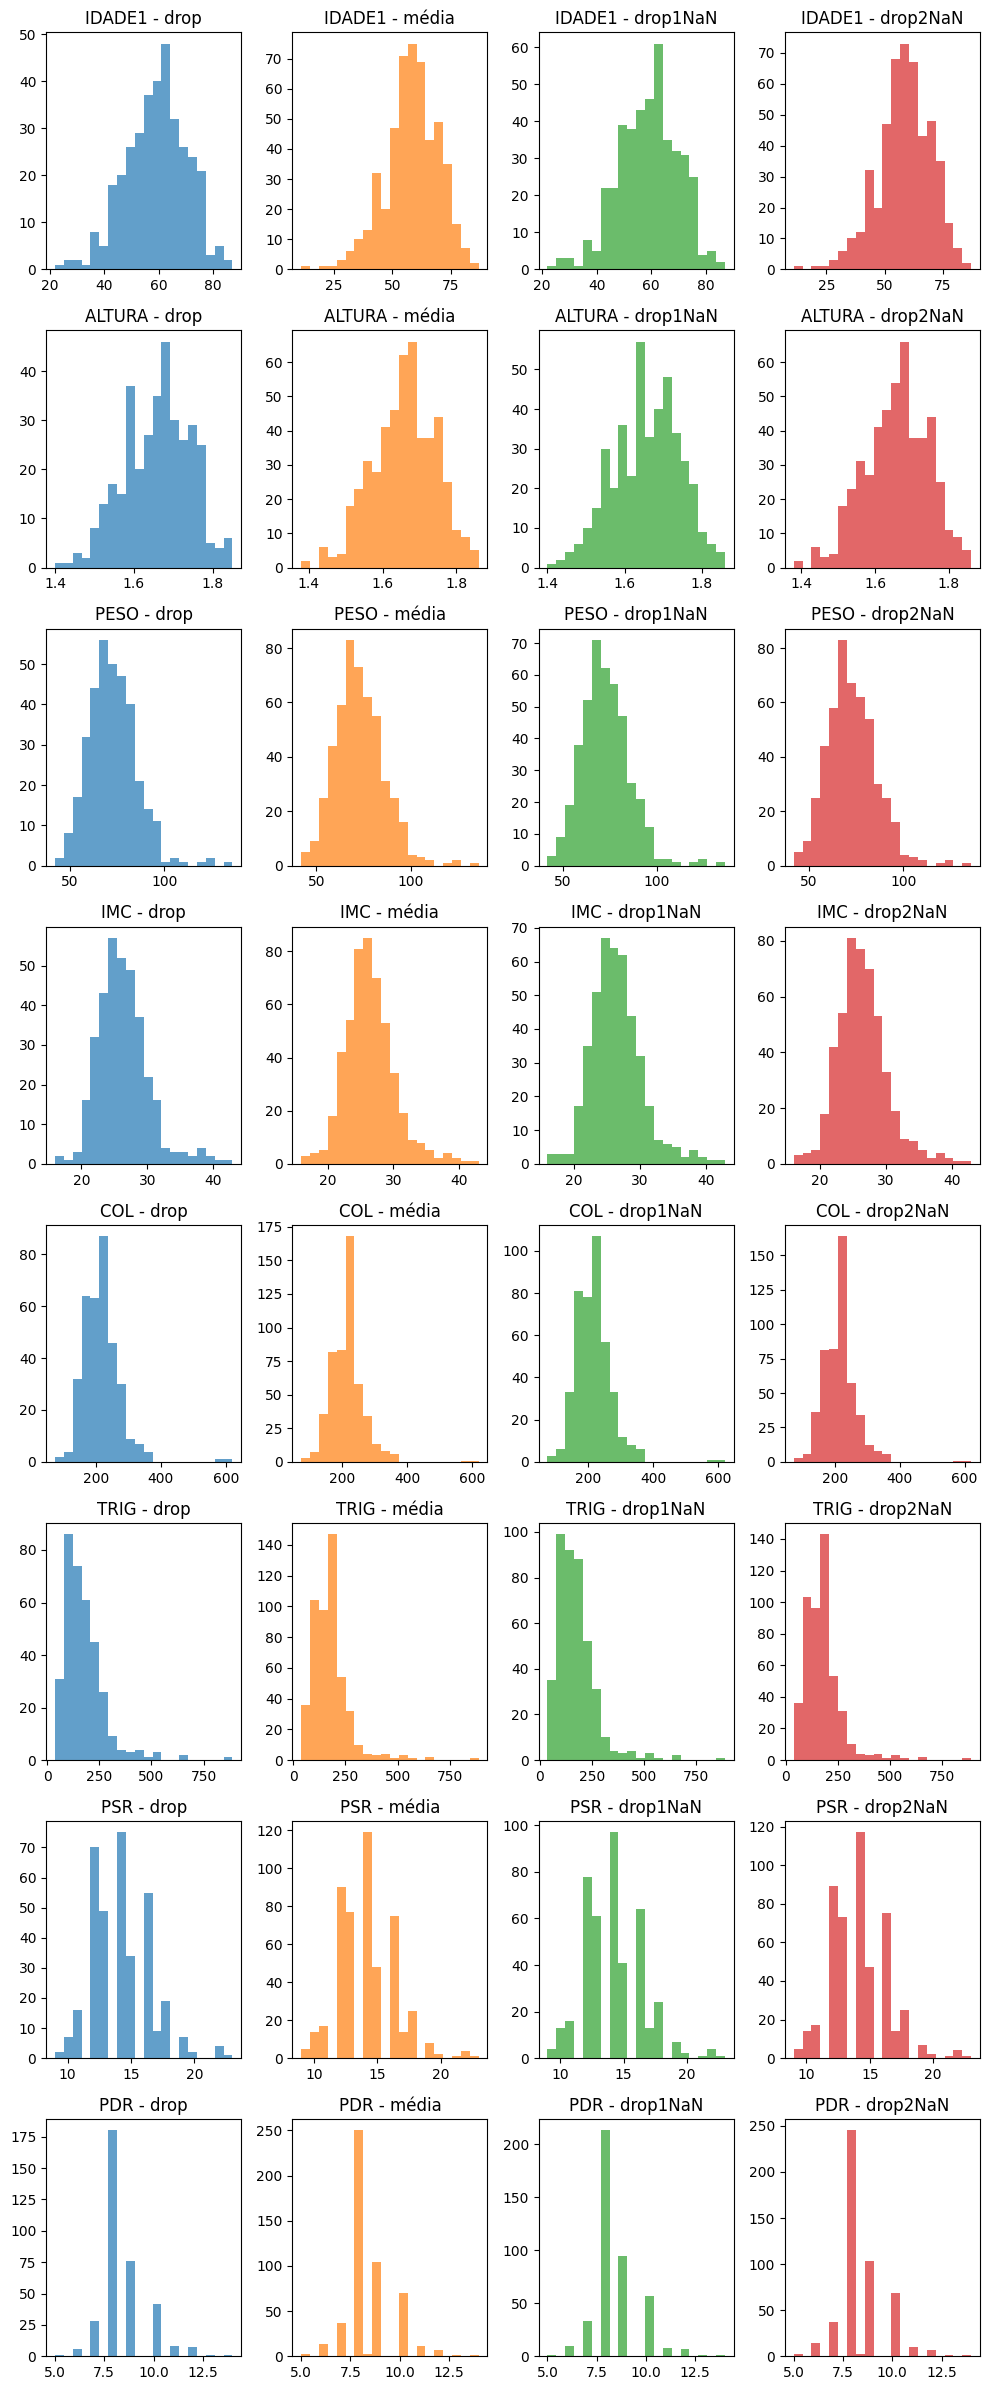

In [81]:
# Visualização rápida do impacto nas distribuições (opcional)
import matplotlib.pyplot as plt

cols_plot = [c for c in quantitativas if c in df.columns]

fig, axes = plt.subplots(len(cols_plot), 4, figsize=(10, 3*len(cols_plot)))
for i, c in enumerate(cols_plot):
    axes[i,0].hist(cenario_a[c].dropna(), bins=20, color='tab:blue', alpha=0.7)
    axes[i,0].set_title(f"{c} - drop")
    axes[i,1].hist(cenario_b[c].dropna(), bins=20, color='tab:orange', alpha=0.7)
    axes[i,1].set_title(f"{c} - média")
    axes[i,2].hist(cenario_c[c].dropna(), bins=20, color='tab:green', alpha=0.7)
    axes[i,2].set_title(f"{c} - drop1NaN")
    axes[i,3].hist(cenario_d[c].dropna(), bins=20, color='tab:red', alpha=0.7)
    axes[i,3].set_title(f"{c} - drop2NaN")
plt.tight_layout()
plt.show()


### Como decidir entre remover linhas e imputar pela média
- Se a porcentagem de faltantes (`perc_na`) em uma variável quantitativa for alta, a imputação pela média tende a distorcer a variância e achataria a distribuição. Prefira remoção se a amostra continuar adequada.
- Se for baixa (ex.: < 5%-10%) e você precisa de mais linhas para modelos, imputar média pode ser aceitável, observando a mudança em `variancia`, `desvio`, `q1/q3` e `p5/p95`.
- Diferença: a **variância** mede a dispersão média ao quadrado (unidade ao quadrado); o **desvio padrão** é a raiz da variância (mesma unidade da variável), logo mais interpretável.
- Para variáveis categóricas, avalie se faz sentido criar uma categoria 'Desconhecido' dependendo do uso.
- Use `comparacao_q` para ver como `media`, `mediana`, `variancia`, `desvio` e separatrizes mudam em cada variável.



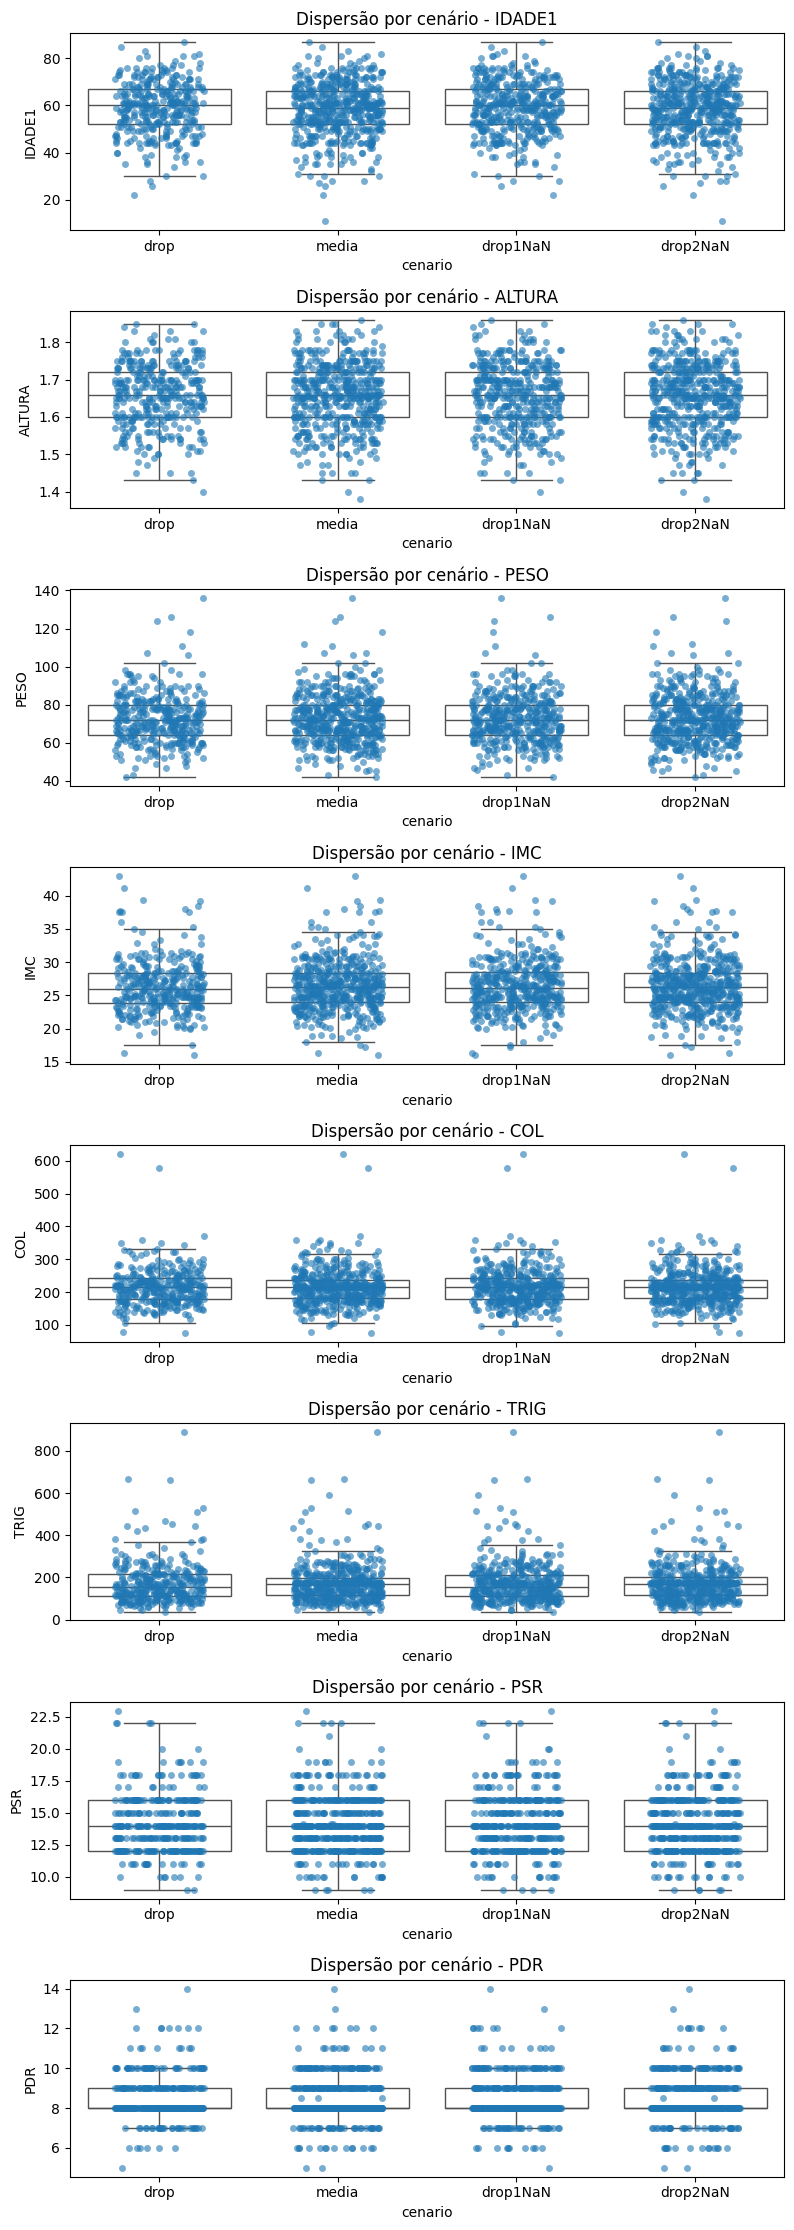

In [82]:
# Gráficos de pontos (stripplot) por variável comparando os cenários
import seaborn as sns

num_cols = [c for c in quantitativas if c in df.columns]

import matplotlib.pyplot as plt
n = len(num_cols)
fig, axes = plt.subplots(n, 1, figsize=(8, 2.8*n), sharex=False)
if n == 1:
    axes = [axes]

for ax, col in zip(axes, num_cols):
    tmp = pd.concat([
        cenario_a[[col]].assign(cenario='drop'),
        cenario_b[[col]].assign(cenario='media'),
        cenario_c[[col]].assign(cenario='drop1NaN'),
        cenario_d[[col]].assign(cenario='drop2NaN')
    ])
    sns.stripplot(data=tmp, x='cenario', y=col, ax=ax, alpha=0.6, jitter=0.25)
    sns.boxplot(data=tmp, x='cenario', y=col, ax=ax, whis=1.5, showcaps=True,
                boxprops={'facecolor':'None'}, showfliers=False)
    ax.set_title(f'Dispersão por cenário - {col}')
plt.tight_layout()
plt.show()


,categoria,freq_drop,freq_rel_drop,freq_moda,freq_rel_moda
0,0,89,25.428571,148,29.6
1,1,261,74.571429,352,70.4


,categoria,freq_drop,freq_rel_drop,freq_moda,freq_rel_moda
0,0,138,39.428571,207,41.4
1,1,110,31.428571,157,31.4
2,2,102,29.142857,136,27.2


,categoria,freq_drop,freq_rel_drop,freq_moda,freq_rel_moda
0,0,224,64.0,329,65.8
1,1,126,36.0,171,34.2


,categoria,freq_drop,freq_rel_drop,freq_moda,freq_rel_moda
0,0,206,58.857143,297,59.4
1,1,144,41.142857,203,40.6


,categoria,freq_drop,freq_rel_drop,freq_moda,freq_rel_moda
0,0.0,287,82.0,416,83.2
1,1.0,63,18.0,84,16.8


,categoria,freq_drop,freq_rel_drop,freq_moda,freq_rel_moda
0,0.0,307,87.714286,443,88.6
1,1.0,25,7.142857,32,6.4
2,2.0,17,4.857143,24,4.8
3,3.0,1,0.285714,1,0.2


,categoria,freq_drop,freq_rel_drop,freq_moda,freq_rel_moda
0,0,314,89.714286,437,87.4
1,1,36,10.285714,63,12.6


,categoria,freq_drop,freq_rel_drop,freq_moda,freq_rel_moda
0,0.0,135,38.571429,222,44.4
1,1.0,68,19.428571,89,17.8
2,2.0,74,21.142857,96,19.2
3,3.0,70,20.000000,90,18.0
4,4.0,2,0.571429,2,0.4
5,5.0,1,0.285714,1,0.2


,categoria,freq_drop,freq_rel_drop,freq_moda,freq_rel_moda
0,0.0,319,91.142857,454,90.8
1,1.0,31,8.857143,46,9.2


Moda por cenário e se mudou:


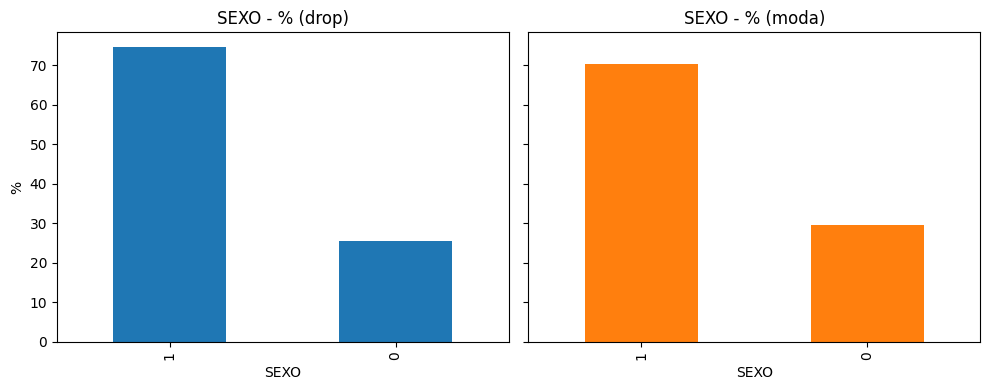

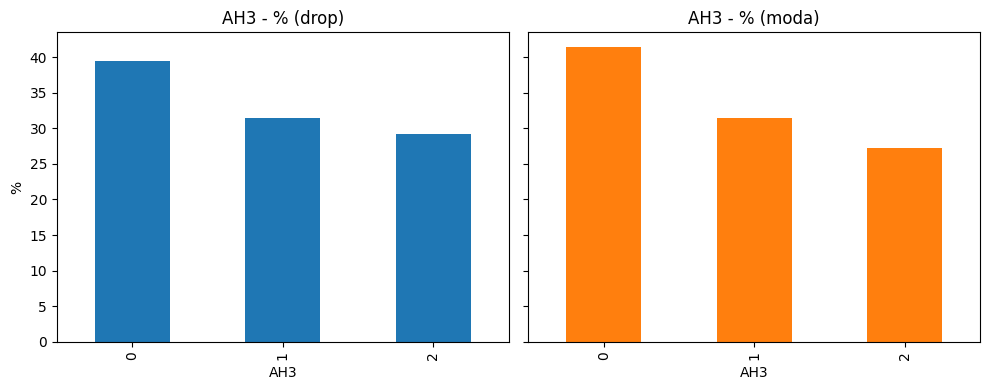

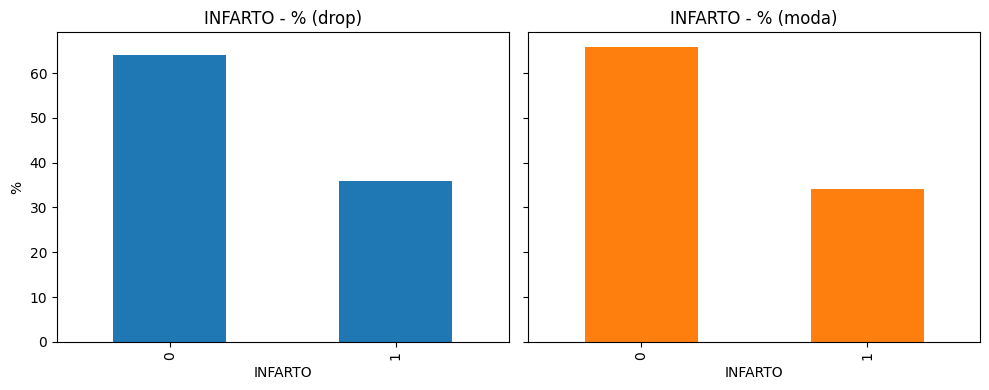

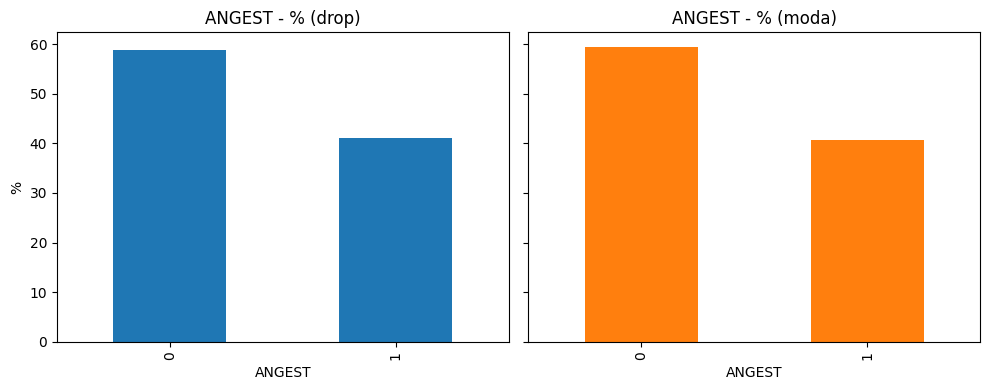

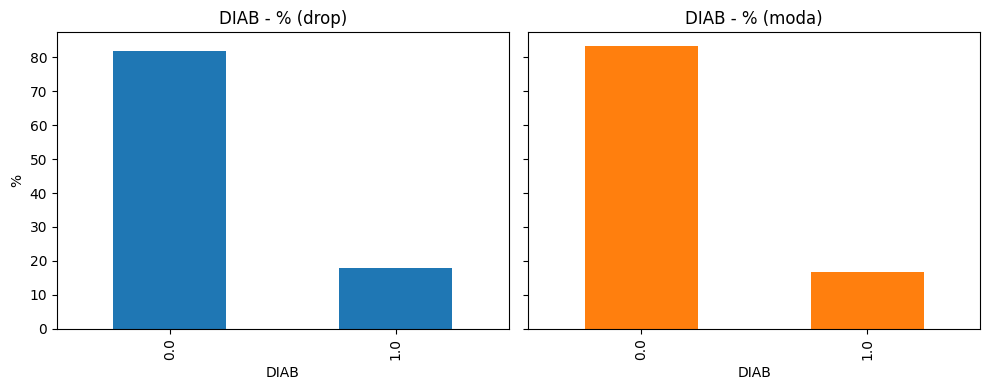

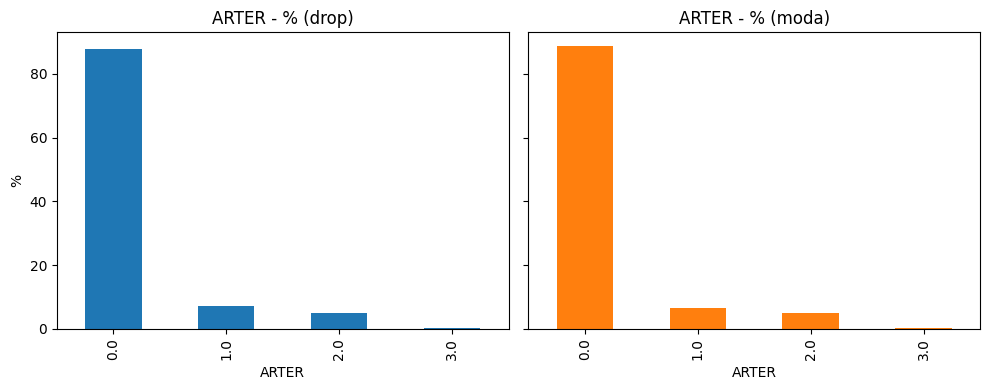

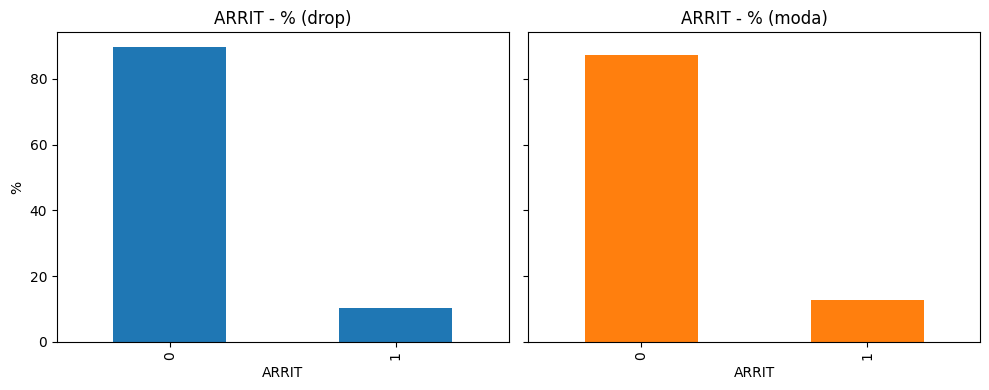

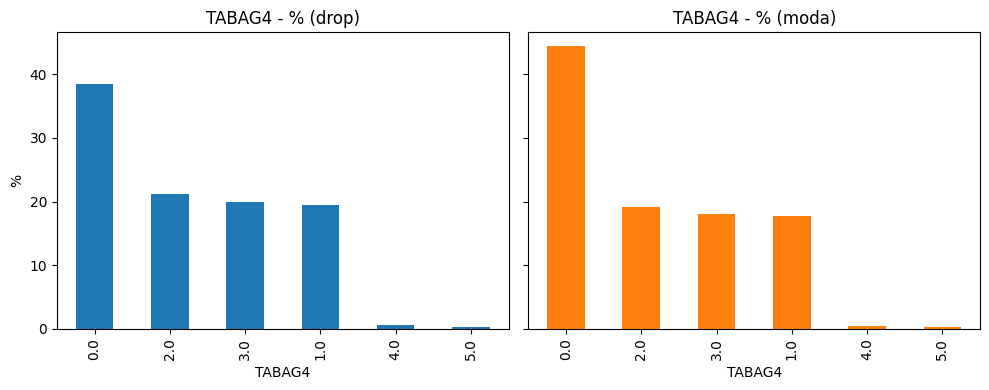

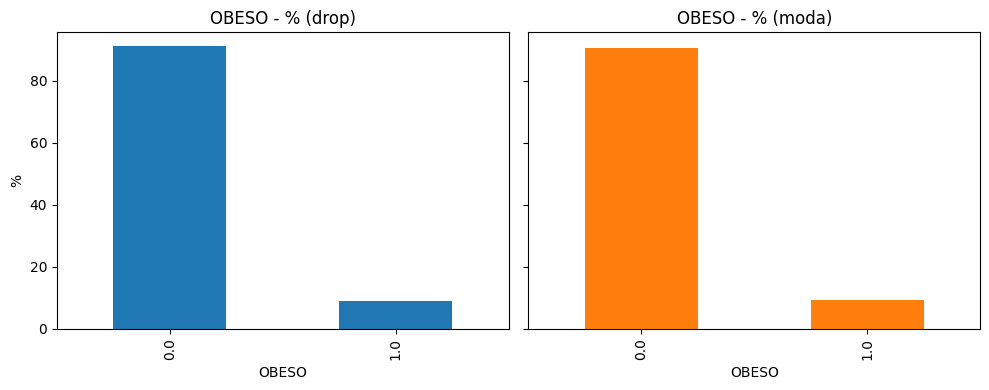

In [83]:
# Categóricas: tabelas de frequências, moda e gráficos de barras em ambos os cenários
import seaborn as sns
import matplotlib.pyplot as plt

cat_cols = [c for c in categoricas if c in df.columns]

# Tabelas de frequências e moda
modas = []
for c in cat_cols:
    tab_a = cenario_a[c].value_counts(dropna=False)
    tab_b = cenario_b[c].value_counts(dropna=False)
    moda_a = cenario_a[c].mode(dropna=False)
    moda_b = cenario_b[c].mode(dropna=False)
    moda_a = moda_a.iloc[0] if not moda_a.empty else np.nan
    moda_b = moda_b.iloc[0] if not moda_b.empty else np.nan
    modas.append({'variavel': c, 'moda_drop': moda_a, 'moda_media': moda_b, 'mudou_moda': moda_a != moda_b})
    
    # DataFrames com absoluta e relativa
    df_tab = pd.DataFrame({
        'categoria': tab_a.index.astype(str),
        'freq_drop': tab_a.values,
        'freq_rel_drop': (tab_a / tab_a.sum() * 100).values
    })
    tab_b_df = pd.DataFrame({
        'categoria': tab_b.index.astype(str),
        'freq_moda': tab_b.values,
        'freq_rel_moda': (tab_b / tab_b.sum() * 100).values
    })
    df_tab = df_tab.merge(tab_b_df, on='categoria', how='outer').fillna(0)
    display(df_tab.sort_values('categoria'))

modas_df = pd.DataFrame(modas)
print('Moda por cenário e se mudou:')
modas_df

# Gráficos de barras lado a lado
for c in cat_cols:
    fig, axes = plt.subplots(1,2, figsize=(10,4), sharey=True)
    # Cenário drop
    vc_a = cenario_a[c].value_counts(dropna=False)
    (vc_a / vc_a.sum() * 100).plot(kind='bar', ax=axes[0], color='tab:blue')
    axes[0].set_title(f'{c} - % (drop)')
    axes[0].set_ylabel('%')
    # Cenário média (categorias não são imputadas, mas o conjunto de linhas muda)
    vc_b = cenario_b[c].value_counts(dropna=False)
    (vc_b / vc_b.sum() * 100).plot(kind='bar', ax=axes[1], color='tab:orange')
    axes[1].set_title(f'{c} - % (moda)')
    plt.tight_layout()
    plt.show()

